In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    
    
### DATA STRUCTURE
### Rewriting all data into an array [beta, ek, vk, [G, S]]
PATH = "../data/U2c0_b30.jld2"
f = h5py.File(PATH, 'r')

### Unique parameters
unique_ek = []
unique_vk = [] 
unique_beta = [] 
for n,para in enumerate(f["Set1"]["Parameters"]):
    if para[0] not in unique_ek:
        unique_ek.append(para[0])
    if para[2] not in unique_vk:
        unique_vk.append(para[2])
    if para[6] not in unique_beta:
        unique_beta.append(para[6])
unique_beta = np.array(unique_beta)
unique_ek = np.array(unique_ek)
unique_vk = np.array(unique_vk)

### Book-keeping between indices of 'data' and actual parameter [beta, ek, vk]
idx_to_para = np.zeros((unique_beta.shape[0], unique_ek.shape[0], unique_vk.shape[0], 3))
n = 0
for b, beta in enumerate(unique_beta):    
    for e, ek in enumerate(unique_ek):    
        for v, vk in enumerate(unique_vk):    
            idx_to_para[b,e,v] = np.array([beta, ek, vk])

### Array
data = np.zeros((unique_beta.shape[0], unique_ek.shape[0], unique_vk.shape[0], 2, 200), dtype=complex)
for n,para in enumerate(f["Set1"]["Parameters"]):
    # jld2 Format fksp complex numbers and stores them into tuples.
    g = []
    s = []
    for gg in f["Set1"]["GImp"][n,:]:
        g.append(gg[0] + 1j*gg[1])
    g = np.array(g)
    for ss in f["Set1"]["SImp"][n,:]:
        s.append(ss[0] + 1j*ss[1])
    s = np.array(s)
    idx = np.argwhere((idx_to_para == np.array([para[6],  para[0], para[2]])).all(-1))[0]
    data[idx[0],idx[1],idx[2],0] = g
    data[idx[0],idx[1],idx[2],1] = s




In [3]:
## STRATEGY 3
## If gradient of sigma is positive at origin -> Insulator

from scipy.optimize import curve_fit

def fit_ImSigma_3(iw, gamma, alpha, beta, delta):
    ImSigma = -gamma - alpha * iw - beta * iw**2 - delta * iw**3
    return ImSigma

phase = np.zeros((100,100))
grad = np.zeros((100,100))
fitpoints = 15
ftp = np.linspace(0,fitpoints,fitpoints, dtype=int)
iv = (2*ftp - 1) / beta * np.pi

# Trend = "Sigma"
Trend = "G"

for b in range(0,1): # Currently only a single beta in each file (Julia script does that)
    met = []
    iso = []
    for n1 in range(0,100):
        for n2 in range(0,100):
            # d = data[b,n1,n2,0,1].imag - data[b,n1,n2,0,0].imag
            # grad[n1,n2] = d

            if Trend == "G":
                giv = (data[b,n1,n2,0,0:fitpoints]).imag
                popt2, pcov2 = curve_fit(fit_ImSigma_3, iv, giv)
                d = popt2[1]
                grad[n1,n2] = d
                if d > 0:
                    phase[n1,n2] = -1
                if d < 0:
                    phase[n1,n2] = 1
            if Trend == "Sigma":
                siv = (data[b,n1,n2,1,0:fitpoints]).imag
                popt2, pcov2 = curve_fit(fit_ImSigma_3, iv, siv)
                d = popt2[1]
                grad[n1,n2] = d
                if d < 0:
                    phase[n1,n2] = -1
                if d > 0:
                    phase[n1,n2] = 1

transition = np.zeros(100) - 1
transition_proximity = np.zeros((100,100)) - 1

ref = phase[n1,0]
for n1 in range(0,100):
    for n2 in range(0,100):
        if (ref-phase[n1,n2])!=0:
            transition[n1] = n2
            ref = phase[n1,n2]

data_split = {}
data_split["metiso"] = {}
data_split["transprox"] = {}
data_split["metiso"]["parameters"] = []
data_split["transprox"]["parameters"] = []
data_split["metiso"]["data"] = []
data_split["transprox"]["data"] = []

for n1 in range(0,100):
    if transition[n1]!=-1:
        for t2 in range(-3,4):
            nt2 = int(transition[n1]+t2)
            if (nt2 > -1) and (nt2 < 100):
                transition_proximity[n1,nt2] = 1

for n1 in range(0,100):
    for n2 in range(0,100):
        if transition_proximity[n1,n2] == 1:
            data_split["transprox"]["data"].append(data[0,n1,n2])
            data_split["transprox"]["parameters"].append(idx_to_para[0,n1,n2])
        else:
            data_split["metiso"]["data"].append(data[0,n1,n2])
            data_split["metiso"]["parameters"].append(idx_to_para[0,n1,n2])

data_split["transprox"]["data"] = np.array(data_split["transprox"]["data"])
data_split["transprox"]["parameters"] = np.array(data_split["transprox"]["parameters"])
data_split["metiso"]["data"] = np.array(data_split["metiso"]["data"])
data_split["metiso"]["parameters"] = np.array(data_split["metiso"]["parameters"])
                
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
f = h5py.File(f"../data/{Trend}Trans/U2c0_b{unique_beta[0]}_1.hdf5", "w")
for b in unique_beta:
    f.create_dataset(f'transprox/data/{str(b)}', data = data_split["transprox"]["data"])
    f.create_dataset(f'transprox/parameters/{str(b)}', data = data_split["transprox"]["parameters"])
    f.create_dataset(f'metiso/data/{str(b)}', data = data_split["metiso"]["data"])
    f.create_dataset(f'metiso/parameters/{str(b)}', data = data_split["metiso"]["parameters"])
f.close()

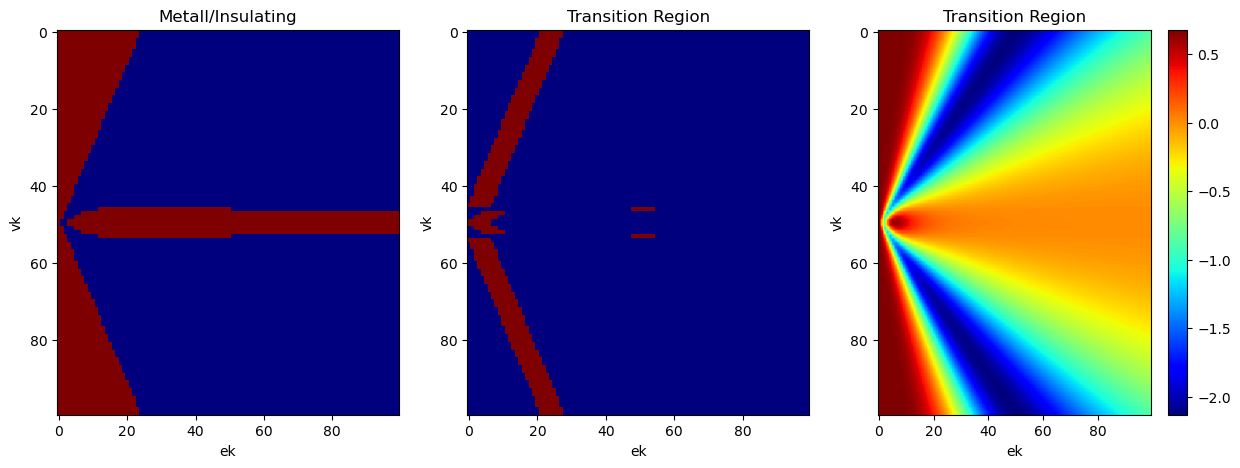

In [12]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
p = ax[0].imshow(phase[:,:].real, aspect="auto", cmap="jet")
ax[0].set_xlabel("ek")
ax[0].set_ylabel("vk")
ax[0].set_title("Metall/Insulating")
# fig.colorbar(p, ax=ax[0])

p = ax[1].imshow(transition_proximity[:,:].real, aspect="auto", cmap="jet")
ax[1].set_xlabel("ek")
ax[1].set_ylabel("vk")
ax[1].set_title("Transition Region")

p = ax[2].imshow(grad[:,:].real, aspect="auto", cmap="jet")
ax[2].set_xlabel("ek")
ax[2].set_ylabel("vk")
ax[2].set_title("Transition Region")
fig.colorbar(p, ax=ax[2])

# p = ax[1].imshow(grad[:,:].real, aspect="auto", cmap="jet")
# ax[1].set_xlabel("ek")
# ax[1].set_ylabel("vk")
# ax[1].set_title("Sigma Gradient")
# fig.colorbar(p, ax=ax[1])



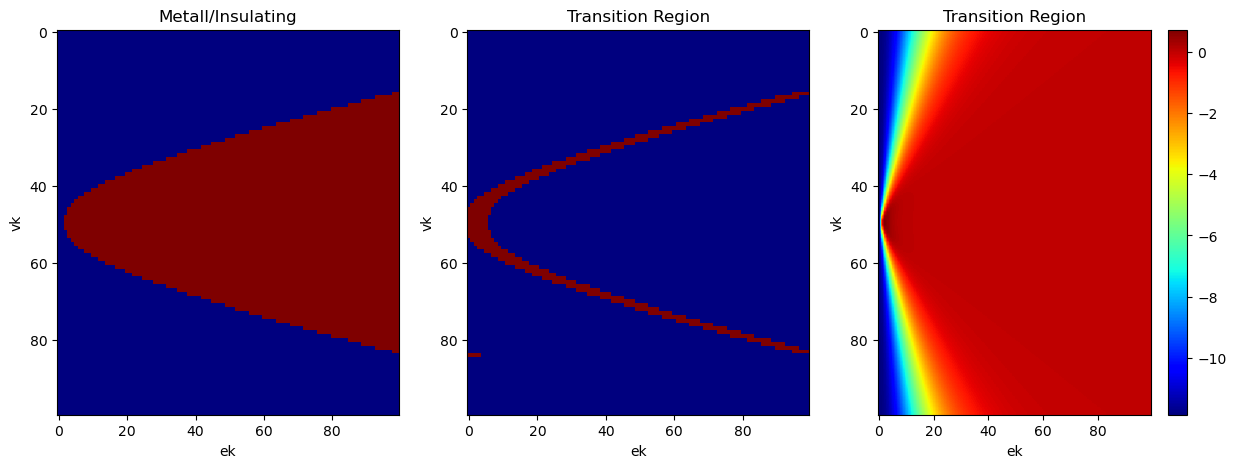

In [14]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
p = ax[0].imshow(phase[:,:].real, aspect="auto", cmap="jet")
ax[0].set_xlabel("ek")
ax[0].set_ylabel("vk")
ax[0].set_title("Metall/Insulating")
# fig.colorbar(p, ax=ax[0])

p = ax[1].imshow(transition_proximity[:,:].real, aspect="auto", cmap="jet")
ax[1].set_xlabel("ek")
ax[1].set_ylabel("vk")
ax[1].set_title("Transition Region")

p = ax[2].imshow(grad[:,:].real, aspect="auto", cmap="jet")
ax[2].set_xlabel("ek")
ax[2].set_ylabel("vk")
ax[2].set_title("Transition Region")
fig.colorbar(p, ax=ax[2])

# p = ax[1].imshow(grad[:,:].real, aspect="auto", cmap="jet")
# ax[1].set_xlabel("ek")
# ax[1].set_ylabel("vk")
# ax[1].set_title("Sigma Gradient")
# fig.colorbar(p, ax=ax[1])

